# Проект: вариант 2  
## Задание 1. A/B–тестирование
1.1 Условие  

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.  

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:  
groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)  
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.   
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.   
1.3 Вопросы  

Предлагаем Вам ответить на следующие вопросы:  

На какие метрики Вы смотрите в ходе анализа и почему?  
Имеются ли различия в показателях и с чем они могут быть связаны?  
Являются ли эти различия статистически значимыми?  
Стоит ли запускать новую механику на всех пользователей?  
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.  

1.4 Требования к ответу  

При выполнении тестового задания необходимо использовать язык программирования Python.   
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными.   
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.  

In [104]:
# Импортируем нужные библиотеки
import pandas as pd
import requests 
from urllib.parse import urlencode 
from scipy.stats import chi2_contingency
from scipy.stats import levene
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph

In [105]:
# Функция для чтения датасетов с Яндекс-диска
def readme(key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = key 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [106]:
# Ссылки на наши датасеты
groups_key='https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_later_key='https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
users_key='https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_key='https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [107]:
# Вызываем функцию readme
groups_url=readme(groups_key)
groups_later_url=readme(groups_later_key)
users_url=readme(users_key)
checks_url=readme(checks_key)

In [108]:
# Сохраняем файлы в переменные. Поскольку разделители для двух датасетов нужно указать явно, 
# мы не можем обобщить этот этап в функции readme
groups=pd.read_csv(groups_url, sep=';').drop_duplicates()
groups_later=pd.read_csv(groups_later_url).drop_duplicates()
users=pd.read_csv(users_url).drop_duplicates() # Сразу же удаляем возможные дубликаты
checks=pd.read_csv(checks_url, sep=';') # Здесь не удаляем: пользователь мог совершить несколько покупок на одинаковую сумму

In [109]:
# Убедимся в том, что всё правильно считалось
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [110]:
groups_later.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [111]:
users.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [112]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### 1. EDA-анализ

In [113]:
checks.student_id.nunique()

541

In [114]:
checks.student_id.count()

541

В таблице все id приводятся один раз - нам не придётся считать сумму по каждому id

Проверим, есть ли пропущенные значения в таблицах.

In [115]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [116]:
groups_later.isna().sum()

id     0
grp    0
dtype: int64

In [117]:
users.isna().sum()

student_id    0
dtype: int64

In [118]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Проверим, что колонка "оплата" содержит данные верного типа (float)

In [119]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [120]:
# Объединим таблицы groups и groups_later
# Проверим, содержатся ли повторяющиеся данные в таблице groups и groups_later
groups_all=groups.append(groups_later)
groups_all[groups_all.duplicated()]

,id,grp


In [121]:
# Проверим, что каждый пользователь попал только в одну группу
groups_all[groups_all.grp=='B'].id.count()+groups_all[groups_all.grp=='A'].id.count()

74576

In [122]:
groups_all.id.nunique() # Всё в порядке

74576

In [123]:
# Посмотрим, как разделили генеральную совокупность пользователей
groups_all.grp.value_counts()

B    59883
A    14693
Name: grp, dtype: int64

В целевой группе пользователей примерно в 4 раза больше, чем в контрольной.

In [124]:
# Объединим таблицы groups_all и users, чтобы оставить информацию только о тех, кто посетил сайт в день тестирования
users=users.rename(columns={'student_id':'id'})
experiment=users.merge(groups_all, on='id', how='left') # left, чтобы оставить только тех, кто посетил сайт

In [125]:
# Посмотрим, сколько пользователей в разных группах
experiment.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [126]:
# Объединим таблицы checks и experiment и получим число людей, оплативших услуги
checks=checks.rename(columns={'student_id':'id'})
ab_test=checks.merge(experiment, on='id', how='left')
ab_test.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

### 2. A/B-тест

Поскольку мы тестируем механизм оплаты, нас будут интересовать именно те пользователи, которые что-то купили в день теста. 
На мой взгляд, эффективны две метрики:  
1. Средний чек.  
2. Конверсия из посещения в покупку.

Эти метрики удобны, так как неравномерное распределение пользователей по группам не оказывает на них влияния.

### 2.1 Средний чек

(array([33., 19., 11.,  3.,  1.,  2.,  0.,  6.,  0.,  3.]),
 array([ 199. ,  545.1,  891.2, 1237.3, 1583.4, 1929.5, 2275.6, 2621.7,
        2967.8, 3313.9, 3660. ]),
 <a list of 10 Patch objects>)

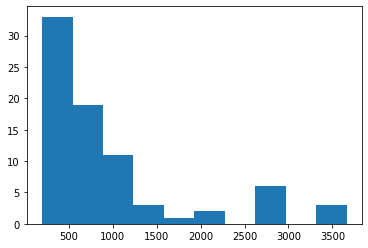

In [127]:
# Посмотрим на распределение выручки в группах А и B
plt.hist(x = ab_test[ab_test.grp=='A'].rev) #Группа А

(array([ 91.,  59.,  17., 130.,   7.,   0.,   7.,   2.,   0.,   1.]),
 array([ 199. ,  644.1, 1089.2, 1534.3, 1979.4, 2424.5, 2869.6, 3314.7,
        3759.8, 4204.9, 4650. ]),
 <a list of 10 Patch objects>)

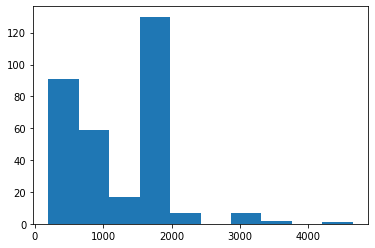

In [128]:
plt.hist(x = ab_test[ab_test.grp=='B'].rev) #Группа B

В обеих группах распределение сумм отличается от нормального.  
В группе В встречаются покупки на сумму более 4000 у.е. Сложно сказать: связано ли это с успехом новой механики или с размером выборки, превышающим в 4 раза размер группы А.

In [129]:
# Посчитаем средний чек в группах A и B
ab_test.groupby('grp', as_index=False).agg({'rev':'mean'})

,grp,rev
0,A,933.589744
1,B,1257.878992


Кажется, что в целевой группе средний чек выше. Проверим значимость этого различия с помощью статистического теста.  
Все тесты будем проводить при уровне значимости 0.05.

In [130]:
# Проведём тест Левена на равенство дисперсий
levene(ab_test[ab_test.grp=='A'].rev, ab_test[ab_test.grp=='B'].rev)

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

p-value превышает 0.05, следовательно, нет оснований отклонить нулевую гипотезу о равенстве дисперсий.

Распределение отличается от нормального, но с учётом размера выборок этим можно пренебречь.  

Наша цель - оценить различия количественной переменной в двух группах.  
Воспользуемся t-тестом Стьюдента.   
Сформулируем гипотезы:  
H0 - средний чек в группах А и В не отличается    
H1 - средний чек в группах А и В отличается

In [131]:
ttest_ind(ab_test[ab_test.grp=='A'].rev,ab_test[ab_test.grp=='B'].rev)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

Значение p-value меньше 0.05, следовательно, у нас есть основание отклонить нулевую гипотезу и заключить, что различия среднего чека в группах значимы.   
**Вывод**: после внедрения новой механики оплаты средний чек вырос.

### 2.2 Конверсия в покупку

Чтобы оценить разницу в конверсии, недостаточно просто посчитать её.  
Нам придётся вернуться на этап объединения таблиц и учесть пользователей, которые были активны, но ничего не купили.

In [132]:
# Чтобы выделить тех, кто был активен, создадим столбец с бинарной переменной
users['active']=1
users.head()

,id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [133]:
# Чтобы выделить тех, кто произвёл оплату, создадим столбец с бинарной переменной
checks['paid']=1
checks.head()

,id,rev,paid
0,1627,990.0,1
1,3185,690.0,1
2,25973,690.0,1
3,26280,690.0,1
4,100300,990.0,1


In [134]:
# Объединяем таблицы users и checks так, чтобы все пользователи попали в таблицу
conversion=users.merge(checks, on='id', how='outer').fillna(0)
conversion.head(3)

,id,active,rev,paid
0,581585,1.0,0.0,0.0
1,5723133,1.0,0.0,0.0
2,3276743,1.0,0.0,0.0


In [135]:
conversion.id.count()

8490

In [136]:
# Проверим, что среди оплативших нет тех, кого не было на сайте
conversion[(conversion.active==0)&(conversion.paid==1)].id.count()

149

Таких аж 149 человек. Они нам не нужны, потому что мы оцениваем переход из посещения в покупку. Удалим эти строки.

In [137]:
conversion=conversion[conversion.active==1]
conversion.id.count() # Верно, таблица стала на 149 строк меньше

8341

In [138]:
# Объединим таблицы conversion и groups_all
conv=conversion.merge(groups_all,on='id')
conv

,id,active,rev,paid,grp
0,581585,1.0,0.0,0.0,A
1,5723133,1.0,0.0,0.0,A
2,3276743,1.0,0.0,0.0,B
3,4238589,1.0,0.0,0.0,A
4,4475369,1.0,0.0,0.0,B
...,...,...,...,...,...
8336,1794344,1.0,0.0,0.0,B
8337,296883,1.0,0.0,0.0,B
8338,3598448,1.0,0.0,0.0,B
8339,3610547,1.0,290.0,1.0,B


Посчитаем конверсию, чтобы сформулировать нулевую гипотезу.  
Конверсия - это отношение числа покупок к числу посещений.

In [139]:
conv_grouped=conv.groupby('grp', as_index=False)\
.agg({'paid':'sum', 'active':'sum'})
conv_grouped['conv']=round(conv_grouped['paid']/conv_grouped['active']*100,2)
conv_grouped

,grp,paid,active,conv
0,A,78.0,1538.0,5.07
1,B,314.0,6803.0,4.62


Кажется, что конверсия уменьшилась с внедрением новой механики оплаты.  
Проверим это предположение с помощью стат. теста.  
Поскольку мы оцениваем категориальную переменную (пользователь либо купил - 1, либо не купил - 0), воспользуемся критерием хи-квадрат.

H0: конверсия не зависит от механики оплаты  
H1: конверсия зависит от механики оплаты

In [140]:
# Составим таблицу сопряжённости
cross_table=pd.crosstab(index=conv['grp'], columns=conv['paid'])

In [141]:
chi2, p, dof, ex=chi2_contingency(cross_table)
p

0.48625240457231045

Мы получили p-value > 0.05, поэтому нет оснований отклонить нулевую гипотезу.  
**Вывод**: с внедрением новой механики оплаты конверсия из посещения в покупку не изменилась.

### Общий вывод.
Конверсия не изменилась, а средний чек платящего пользователя увеличился. Это говорит о том, что новую механику оплаты можно распространить на всех пользователей.  
Однако хотелось бы иметь дело с более сбалансированным сплитом пользователей, поскольку целевая группа получилась более вариативной и поэтому нельзя говорить об одинаковой представительности в двух группах. И не совсем понятно, как можно оплатить услугу, не заходя на сайт.

## Задание 2. SQL

### 1. Очень усердные ученики
2.1.1 Условие и задание 

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".  

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.  
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.  

In [142]:
# Будем подключаться к ClickHouse
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }
# Предварительный запрос в Redash показал, 
# что данные представлены за один месяц - октябрь 2021 года. 
# Фильтрация по дате не имеет смысла
"""select
    cast(date_trunc('month', timest) as date) as true_date, count(true_date)
    from default.peas
    group by true_date"""
# Запрос в Redash
q = '''
    select count (*)
    from (
        select st_id, count(correct)
        from default.peas
        where correct==1
        group by st_id
        having count(correct)>=20
        )
    '''
# Запишем результат выполнения запроса в number_of_hardworkers
number_of_hardworkers = ph.read_clickhouse(query=q, connection=connection_default)
number_of_hardworkers

,count()
0,136


### 2. Оптимизация воронки
2.2.1 Условие и задание  

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.  
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:  
ARPU   
ARPAU   
CR в покупку   
СR активного пользователя в покупку   
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  
ARPU считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

ARPU - средний доход с пользователя,  
ARPAU - средний доход с активного пользователя,  
CR - число покупок к числу пользователей,  
CR_active - число покупок, совершённых активными пользователями, к числу активных пользователей,  
CR_math - число покупок, совершённых мат.-активными пользователями, к числу мат.-активных пользователей,

In [143]:
q='''
select 
    test_grp,
    sum(usual_money)/count(distinct(studs.st_id)) as ARPU,
    sumIf(usual_money, activity>10)/countIf(distinct(studs.st_id), activity>10) as ARPAU,
    countIf(distinct(studs.st_id), usual_money>0)/count(distinct(studs.st_id))*100 as CR,
    countIf(distinct(studs.st_id), usual_money>0 and activity>10)/countIf(distinct(studs.st_id), activity>10)*100 as CR_active,
    countIf(distinct(studs.st_id), math_money>0 and math_activity>=2)/countIf(distinct(studs.st_id), math_activity>=2)*100 as CR_active_math
from 
    default.studs as studs
left join ( --везде будет left join, поскольку ARPU считается относительно всех пользователей, поэтому нужны все id
    select 
        st_id,
        sum(correct) as activity, --обычная активность
        sumIf(correct, subject=='Math') as math_activity --активность по математике
    from default.peas
    group by st_id) as active_groups
on studs.st_id=active_groups.st_id
left join (
    select
        st_id,
        sum(money) as usual_money, --уплаченные за всё подряд; если пользователь неактивный, сумма просто не зачтётся
        sumIf(money, subject=='Math') as math_money --уплаченные только за курс по матану
    from 
        default.final_project_check
        group by st_id) as checks
on studs.st_id=checks.st_id
group by test_grp
       
'''
# Запишем результат выполнения запроса в statistics
statistics = ph.read_clickhouse(query=q, connection=connection_default)
statistics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


Как видим, все метрики увеличились с внедрением нового экрана оплаты.  
Стоит провести a/b-тест, есть основания предпологать, что изменение внесло значимые положительные различия.

## Задание 3. Python
1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### 1. Функция, выводящая метрики


Напишем функцию, которая объединяет уже прочитанные файлы (задание 1) и считает основные показатели.

In [144]:
def update_func(grp,active,chs,new):
    total_groups=grp.append(groups_later).drop_duplicates()
    active=active.rename(columns={'student_id':'id'})
    chs=chs.rename(columns={'student_id':'id'})
    merged_active=active.merge(total_groups,on='id')
    merged_active['active']=1 # Иначе в итоговой таблице будет два столбца id
    #Таблица с активными и платящими - active_and_chs:
    active_and_chs=merged_active.merge(chs, on='id', how='left').fillna(0) 
    statistics=active_and_chs.groupby('grp', as_index=False)\
    .agg({'rev':'sum', 'active':'count'})
    statistics_1=active_and_chs[active_and_chs.rev>0]\
    .groupby('grp', as_index=False)\
    .agg({'id':'count'})
    metrics=statistics.merge(statistics_1,on='grp')
    metrics['CR']=round(metrics['id']/metrics['active']*100,2)
    metrics['ARPPU']=round(metrics['rev']/metrics['id'],2)
    metrics=metrics.rename(columns={'active':'active_users', 'id':'num_of_checks'})
    return metrics

In [145]:
my_metrics=update_func(groups,users,checks,groups_later)
my_metrics

,grp,rev,active_users,num_of_checks,CR,ARPPU
0,A,72820.0000,1538,78,5.07,933.59
1,B,394974.0035,6803,314,4.62,1257.88


### 2. Функция, которая рисует метрики

Будем использовать столбчатую диаграмму.  
Построим две наши метрики.

In [146]:
def plot_me(metrics_table):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    fig.suptitle('Metrics by Groups')
    plt.subplots_adjust(wspace=1)
    with sns.color_palette("husl"):
        sns.barplot(ax=axes[0], data=metrics_table, x='grp', y='CR')
        axes[0].set_xlabel('Group')
    with sns.color_palette("husl"):
        sns.barplot(ax=axes[1], data=metrics_table, x='grp', y='ARPPU')
        axes[1].set_xlabel('Group')

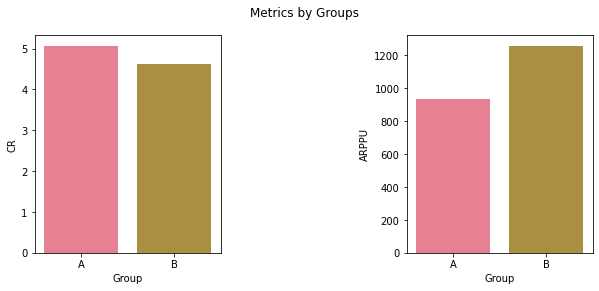

In [147]:
plot_me(my_metrics)